# Single-Cell RNA-seq Cell Annotation Pipeline

This notebook provides an interactive walkthrough of the complete cell annotation pipeline, from raw CellBender output to annotated cell types.

**Authors:** Tsai Lab  
**Last Updated:** 2025-01-11

---

## Table of Contents

1. [Setup & Installation](#setup)
2. [Parameter Configuration](#parameters)
3. [Stage 1: Data Loading & Integration](#stage1)
4. [Stage 2: QC Metrics Calculation & Visualization](#stage2)
5. [Stage 3: Doublet Detection](#stage3)
6. [Stage 4: Cell & Gene Filtering](#stage4)
7. [Stage 5: Normalization & Scaling](#stage5)
8. [Stage 6: PCA, UMAP & Clustering](#stage6)
9. [Stage 7: Marker Gene Analysis](#stage7)
10. [Stage 8: Cell Type Annotation](#stage8)
11. [Stage 9: Reclustering & Export](#stage9)
12. [Summary & Next Steps](#summary)

---

## 1. Setup & Installation

Install required packages and set up the environment.

In [15]:
# Import libraries
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML, Markdown

# Configure settings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')
matplotlib.rcParams['figure.figsize'] = (8, 6)


print("✓ Setup complete!")
print(f"Scanpy version: {sc.__version__}")

✓ Setup complete!
Scanpy version: 1.11.4


### Mount Google Drive (if using Colab)

Uncomment and run if you need to access data from Google Drive.

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_path = "/content/drive/MyDrive/cell_annotation/"

## 2. Parameter Configuration

This section centralizes all tunable parameters for the pipeline. Adjust these based on your data characteristics and analysis goals.

### 🎯 Quick Start Modes

Choose a preset or customize individual parameters below.

In [3]:
# ============================================================================
# PRESET CONFIGURATIONS
# ============================================================================

PRESETS = {
    'default': {
        'name': 'Default (Balanced)',
        'description': 'Standard parameters suitable for most datasets',
    },
    'stringent': {
        'name': 'Stringent QC',
        'description': 'Stricter filtering for high-quality cells only',
    },
    'permissive': {
        'name': 'Permissive QC',
        'description': 'More lenient filtering to retain more cells',
    },
}

# Select your preset here
SELECTED_PRESET = 'default'  # Options: 'default', 'stringent', 'permissive'

print(f"Selected preset: {PRESETS[SELECTED_PRESET]['name']}")
print(f"Description: {PRESETS[SELECTED_PRESET]['description']}")

Selected preset: Default (Balanced)
Description: Standard parameters suitable for most datasets


In [23]:
# ============================================================================
# DATA LOADING PARAMETERS
# ============================================================================

# Path to CellBender output files
BASE_PATH = "data/"  # 🔧 UPDATE THIS PATH

# Sample identifiers
# Example: [f"D25-{i}" for i in range(2675, 2691)] generates D25-2675, D25-2676, ..., D25-2690
SAMPLE_NAMES = [f"D25-{i}" for i in range(2675, 2691)]  # 🔧 CUSTOMIZE YOUR SAMPLES

# CellBender output filename pattern
CUSTOM_NAME = "_processed_feature_bc_matrix_filtered.h5"  # 🔧 UPDATE IF DIFFERENT

# Output directory for plots and results
PLOTS_DIR = Path("plots")
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Data path: {BASE_PATH}")
print(f"Number of samples: {len(SAMPLE_NAMES)}")
print(f"Output directory: {PLOTS_DIR}")

Data path: data/
Number of samples: 16
Output directory: plots


In [24]:
# ============================================================================
# QC FILTERING PARAMETERS
# ============================================================================

# Define parameter sets for each preset
QC_PRESETS = {
    'default': {
        'min_genes': 200,
        'max_genes': 8000,
        'min_counts': 1000,
        'max_counts': 50000,
        'max_mt_pct': 10,
        'max_ribo_pct': None,
    },
    'stringent': {
        'min_genes': 500,
        'max_genes': 6000,
        'min_counts': 1500,
        'max_counts': 40000,
        'max_mt_pct': 5,
        'max_ribo_pct': None,
    },
    'permissive': {
        'min_genes': 100,
        'max_genes': 10000,
        'min_counts': 500,
        'max_counts': 60000,
        'max_mt_pct': 15,
        'max_ribo_pct': None,
    },
}

# Load parameters based on selected preset
CELL_FILTERS = QC_PRESETS[SELECTED_PRESET]

# 🔧 OPTIONAL: Override specific parameters here
# Uncomment and modify any parameter you want to customize:
# CELL_FILTERS['min_genes'] = 300
# CELL_FILTERS['max_mt_pct'] = 8

# Gene-level filters
GENE_FILTERS = {
    'min_cells': 10,  # 🔧 Minimum cells expressing a gene
}

# Mitochondrial and ribosomal gene patterns
GENE_PATTERNS = {
    'mt_pattern': 'mt-',     # 🔧 Use 'MT-' for human, 'mt-' for mouse
    'ribo_pattern': r'^Rp[sl]',  # Ribosomal protein genes
}

# Display current settings
print("Cell-level QC filters:")
for key, value in CELL_FILTERS.items():
    print(f"  {key}: {value}")

print("\nGene-level filters:")
for key, value in GENE_FILTERS.items():
    print(f"  {key}: {value}")

Cell-level QC filters:
  min_genes: 200
  max_genes: 8000
  min_counts: 1000
  max_counts: 50000
  max_mt_pct: 10
  max_ribo_pct: None

Gene-level filters:
  min_cells: 10


In [25]:
# ============================================================================
# DOUBLET DETECTION PARAMETERS
# ============================================================================

DOUBLET_PARAMS = {
    'expected_doublet_rate': 0.10,  # 🔧 10% expected doublet rate (platform-dependent)
    'manual_threshold': 0.35,       # 🔧 Score threshold for doublet classification
    'min_counts': 2,                # Minimum counts for Scrublet filtering
    'min_cells': 3,                 # Minimum cells for Scrublet filtering
    'min_gene_variability_pctl': 85,  # Gene variability percentile
    'n_prin_comps': 30,             # Number of principal components
}

# 💡 Tips for tuning:
# - expected_doublet_rate: 0.06 for 10x v3, 0.08-0.10 for high-throughput
# - manual_threshold: Lower (0.25-0.30) for stricter removal, Higher (0.40-0.45) for permissive

print("Doublet detection parameters:")
for key, value in DOUBLET_PARAMS.items():
    print(f"  {key}: {value}")

Doublet detection parameters:
  expected_doublet_rate: 0.1
  manual_threshold: 0.35
  min_counts: 2
  min_cells: 3
  min_gene_variability_pctl: 85
  n_prin_comps: 30


In [26]:
# ============================================================================
# DIMENSIONALITY REDUCTION & CLUSTERING PARAMETERS
# ============================================================================

# PCA parameters
N_PCS = 15  # 🔧 Number of principal components (check elbow plot to adjust)
N_PCS_COMPUTE = 50  # Number of PCs to compute initially

# kNN graph parameters
N_NEIGHBORS = 10  # 🔧 Number of neighbors (increase for smoother manifolds)

# Leiden clustering parameters
CLUSTERING_PARAMS = {
    'auto_resolution': True,    # 🔧 Automatically select optimal resolution
    'resolution': 0.8,          # 🔧 Fixed resolution (used if auto_resolution=False)
    'resolution_grid': [i/10 for i in range(4, 13)],  # 🔧 Resolution sweep: 0.4-1.2
    'min_cluster_size': 20,     # 🔧 Minimum cells per cluster for quality metrics
}

# 💡 Tips for tuning:
# - N_PCS: Check PCA elbow plot; typically 20-40 for complex tissues
# - N_NEIGHBORS: 10-15 standard, 20-30 for smoother structure
# - resolution_grid: Lower values (0.2-0.8) for coarse clusters, higher (1.0-2.0) for fine-grained

print("Dimensionality reduction parameters:")
print(f"  N_PCS: {N_PCS}")
print(f"  N_NEIGHBORS: {N_NEIGHBORS}")

print("\nClustering parameters:")
for key, value in CLUSTERING_PARAMS.items():
    print(f"  {key}: {value}")

Dimensionality reduction parameters:
  N_PCS: 15
  N_NEIGHBORS: 10

Clustering parameters:
  auto_resolution: True
  resolution: 0.8
  resolution_grid: [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
  min_cluster_size: 20


In [27]:
# ============================================================================
# CELL TYPE ANNOTATION PARAMETERS
# ============================================================================

ANNOTATION_PARAMS = {
    'label_mode': 'cell',      # 🔧 'cell' for per-cell or 'cluster' for cluster-level
    'margin': 0.05,            # 🔧 Confidence margin for label assignment
    'cluster_agg': 'median',   # 🔧 Aggregation for cluster-level ('median' or 'mean')
}

# Marker gene panel (can be customized)
MARKER_GENES = {
    # General neuron/excitatory
    "Neuron": ["Snap25", "Rbfox3", "Syp"],
    "Excit": ["Slc17a7", "Camk2a", "Satb2"],
    # Excitatory layer-specific markers
    "ExN_L2-4": ["Cux1", "Cux2", "Satb2"],
    "ExN_L5": ["Bcl11b", "Ctip2", "Fezf2"],
    "ExN_L6": ["Tbr1", "Sox5"],
    "ExN_L6b": ["Ctgf"],
    # Inhibitory (generic + subclasses)
    "Inhib": ["Gad1", "Gad2", "Slc6a1"],
    "InN_SST": ["Sst", "Npy", "Chodl"],
    "InN_VIP": ["Vip", "Cck", "Calb2"],
    "InN_PVALB": ["Pvalb", "Gabra1", "Reln"],
    # Glia and vascular
    "Astro": ["Slc1a2", "Slc1a3", "Aqp4", "Aldh1l1", "Gfap"],
    "Oligo": ["Plp1", "Mog", "Mobp", "Mbp"],
    "OPC": ["Pdgfra", "Cspg4", "Sox10"],
    "Micro": ["P2ry12", "Tmem119", "Cx3cr1", "Csf1r", "Sall1", "Aif1"],
    "Endo": ["Pecam1", "Kdr", "Flt1", "Klf2", "Slco1a4"],
    "Peri": ["Pdgfrb", "Rgs5", "Kcnj8", "Abcc9"],
    "VLMC": ["Col1a1", "Col1a2", "Lum", "Dcn"],
    "SMC": ["Acta2", "Myh11", "Tagln"],
}

# 💡 Tips for tuning:
# - label_mode='cell': More granular but can be noisy
# - label_mode='cluster': More robust for cleaner annotations
# - margin: Increase (0.10-0.15) for more conservative labeling

print("Annotation parameters:")
for key, value in ANNOTATION_PARAMS.items():
    print(f"  {key}: {value}")

print(f"\nNumber of cell type categories: {len(MARKER_GENES)}")

Annotation parameters:
  label_mode: cell
  margin: 0.05
  cluster_agg: median

Number of cell type categories: 18


In [28]:
# ============================================================================
# PARAMETER SUMMARY
# ============================================================================

def display_parameter_summary():
    """Display a formatted summary of all parameters"""
    summary = f"""
    <div style='background-color: #f0f0f0; padding: 15px; border-radius: 5px; font-family: monospace;'>
    <h3 style='margin-top: 0;'>📋 Parameter Summary</h3>
    
    <b>Preset:</b> {PRESETS[SELECTED_PRESET]['name']}<br>
    
    <b>Data:</b><br>
    &nbsp;&nbsp;Samples: {len(SAMPLE_NAMES)}<br>
    &nbsp;&nbsp;Output: {PLOTS_DIR}<br>
    
    <b>QC Filters:</b><br>
    &nbsp;&nbsp;Genes per cell: {CELL_FILTERS['min_genes']}-{CELL_FILTERS['max_genes']}<br>
    &nbsp;&nbsp;Counts per cell: {CELL_FILTERS['min_counts']}-{CELL_FILTERS['max_counts']}<br>
    &nbsp;&nbsp;Max MT%: {CELL_FILTERS['max_mt_pct']}<br>
    &nbsp;&nbsp;Min cells per gene: {GENE_FILTERS['min_cells']}<br>
    
    <b>Doublet Detection:</b><br>
    &nbsp;&nbsp;Expected rate: {DOUBLET_PARAMS['expected_doublet_rate']*100}%<br>
    &nbsp;&nbsp;Manual threshold: {DOUBLET_PARAMS['manual_threshold']}<br>
    
    <b>Clustering:</b><br>
    &nbsp;&nbsp;PCs: {N_PCS}<br>
    &nbsp;&nbsp;Neighbors: {N_NEIGHBORS}<br>
    &nbsp;&nbsp;Auto-resolution: {CLUSTERING_PARAMS['auto_resolution']}<br>
    &nbsp;&nbsp;Resolution: {CLUSTERING_PARAMS['resolution']}<br>
    
    <b>Annotation:</b><br>
    &nbsp;&nbsp;Mode: {ANNOTATION_PARAMS['label_mode']}<br>
    &nbsp;&nbsp;Margin: {ANNOTATION_PARAMS['margin']}<br>
    </div>
    """
    display(HTML(summary))

display_parameter_summary()
print("\n✓ All parameters configured!")


✓ All parameters configured!


## 3. Stage 1: Data Loading & Integration

Load CellBender-processed data and merge multiple samples.

**Key Parameters:**
- `BASE_PATH`: Path to data directory
- `SAMPLE_NAMES`: List of sample identifiers
- `CUSTOM_NAME`: CellBender output filename pattern

In [31]:
def load_and_merge_cellbender_data(base_path, sample_names, custom_name):
    """Load and merge CellBender H5 files from multiple samples"""
    print(f"Loading {len(sample_names)} samples...")
    
    adatas = []
    for sample in sample_names:
        filepath = f"{base_path}{sample}/{sample}{custom_name}"
        try:
            adata_sample = sc.read_10x_h5(filepath)
            adata_sample.var_names_make_unique()
            adata_sample.obs['sample'] = sample
            adatas.append(adata_sample)
            print(f"  ✓ {sample}: {adata_sample.n_obs} cells, {adata_sample.n_vars} genes")
        except Exception as e:
            print(f"  ✗ Failed to load {sample}: {e}")
    
    if not adatas:
        raise ValueError("No data loaded! Check your paths.")
    
    # Merge all samples
    print("\nMerging samples...")
    adata = adatas[0].concatenate(
        adatas[1:],
        batch_key='sample',
        batch_categories=sample_names,
        index_unique='_'
    )
    
    print(f"\n✓ Merged dataset: {adata.n_obs} cells × {adata.n_vars} genes")
    return adata

def add_metadata(adata, sample_names):
    """Add metadata columns based on sample names"""
    print("\nAdding metadata...")
    
    # Extract metadata from sample names (customize this based on your naming scheme)
    # Example: D25-2675 -> Genotype, Sex, Stimulation
    metadata = pd.DataFrame({
        'sample': sample_names,
        'Genotype': ['WT'] * len(sample_names),  # 🔧 CUSTOMIZE
        'Sex': ['M'] * len(sample_names),        # 🔧 CUSTOMIZE
        'Stimulation': ['Control'] * len(sample_names),  # 🔧 CUSTOMIZE
    })
    
    # Map metadata to cells
    for col in ['Genotype', 'Sex', 'Stimulation']:
        adata.obs[col] = adata.obs['sample'].map(
            dict(zip(metadata['sample'], metadata[col]))
        )
    
    print("  ✓ Metadata added")
    return adata

In [32]:
# Load and merge data
adata = load_and_merge_cellbender_data(BASE_PATH, SAMPLE_NAMES, CUSTOM_NAME)

# Add metadata
adata = add_metadata(adata, SAMPLE_NAMES)

# Display dataset info
print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"Samples: {adata.obs['sample'].nunique()}")
print(f"\nMetadata columns: {list(adata.obs.columns)}")

Loading 16 samples...
reading data/D25-2675/D25-2675_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2675: 13370 cells, 32285 genes
reading data/D25-2676/D25-2676_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2676: 8935 cells, 32285 genes
reading data/D25-2677/D25-2677_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2677: 8345 cells, 32285 genes
reading data/D25-2678/D25-2678_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2678: 8038 cells, 32285 genes
reading data/D25-2679/D25-2679_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2679: 9626 cells, 32285 genes
reading data/D25-2680/D25-2680_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2680: 7590 cells, 32285 genes
reading data/D25-2681/D25-2681_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2681: 10128 cells, 32285 genes
reading data/D25-2682/D25-2682_processed_feature_bc_matrix_filtered.h5
 (0:00:00)
  ✓ D25-2682: 7049 cells, 32285 genes
reading data/D25

## 4. Stage 2: QC Metrics Calculation & Visualization

Calculate quality control metrics and visualize distributions to inform filtering thresholds.

**Key Metrics:**
- `n_genes_by_counts`: Number of genes detected per cell
- `total_counts`: Total UMI counts per cell
- `percent_mt`: Percentage of mitochondrial gene expression
- `percent_ribo`: Percentage of ribosomal gene expression

In [33]:
def calculate_qc_metrics(adata):
    """Calculate QC metrics for cells"""
    print("Calculating QC metrics...")
    
    # Identify mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith(GENE_PATTERNS['mt_pattern'])
    
    # Identify ribosomal genes
    adata.var['ribo'] = adata.var_names.str.match(GENE_PATTERNS['ribo_pattern'])
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt', 'ribo'],
        percent_top=None,
        log1p=False,
        inplace=True
    )
    
    # Rename columns for clarity
    adata.obs['percent_mt'] = adata.obs['pct_counts_mt']
    adata.obs['percent_ribo'] = adata.obs['pct_counts_ribo']
    
    print(f"  ✓ Mitochondrial genes: {adata.var['mt'].sum()}")
    print(f"  ✓ Ribosomal genes: {adata.var['ribo'].sum()}")
    
    return adata

# Calculate metrics
adata = calculate_qc_metrics(adata)

Calculating QC metrics...
  ✓ Mitochondrial genes: 13
  ✓ Ribosomal genes: 101



Plotting QC metrics...
  Saved: plots/qc_violin_plots.png


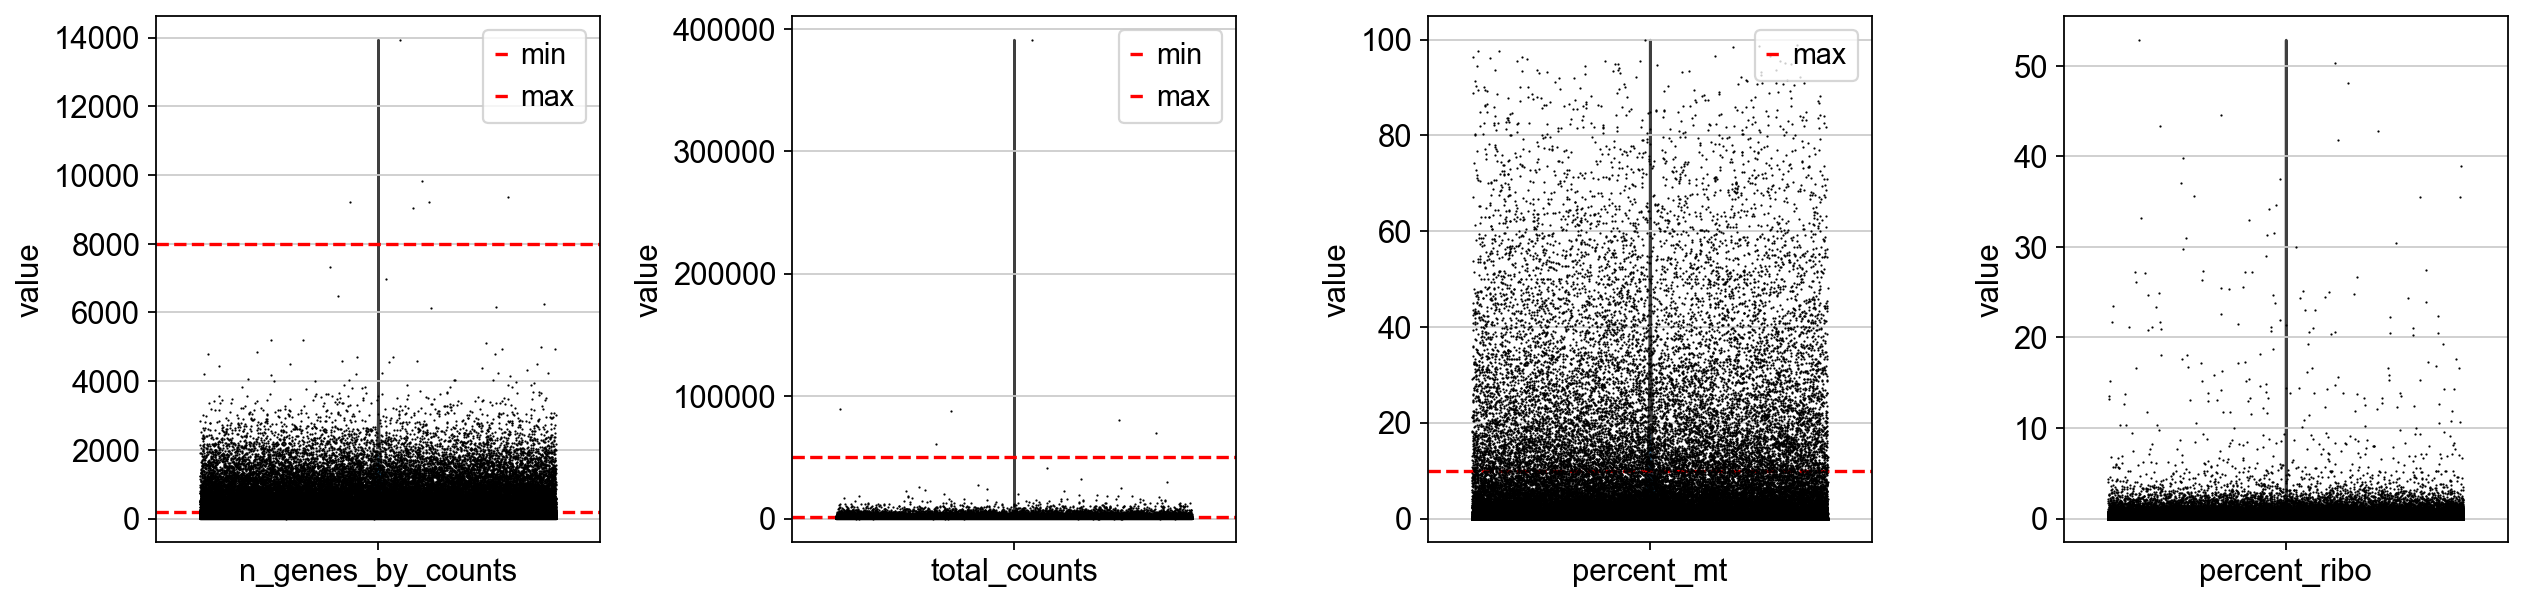

  Saved: plots/qc_scatter_plots.png


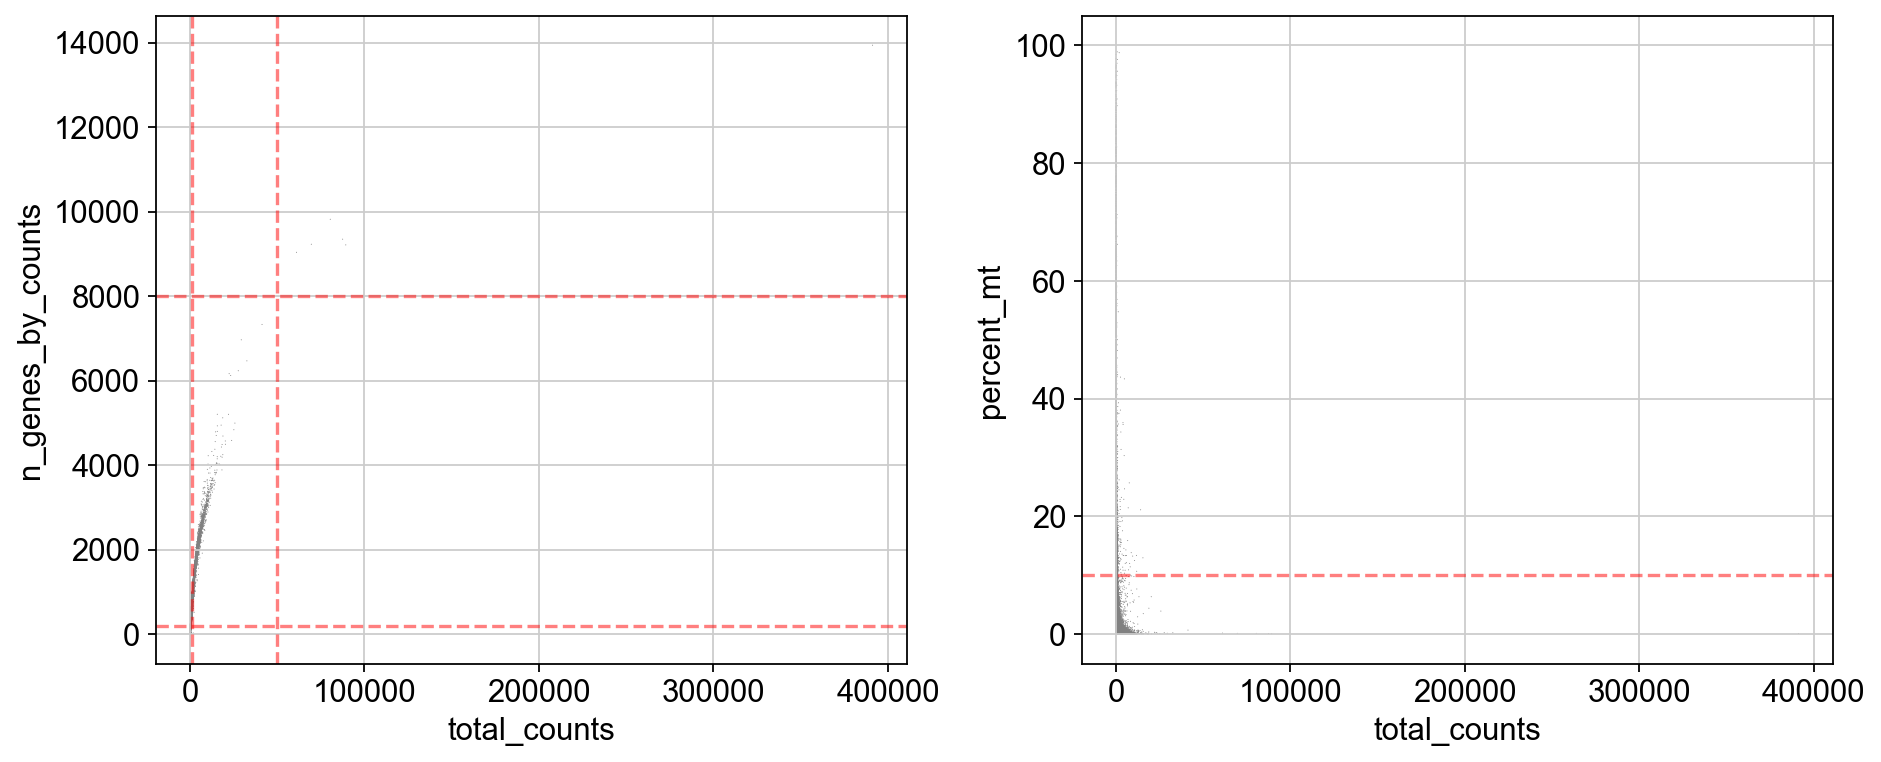


QC Metrics Summary:
       n_genes_by_counts   total_counts     percent_mt   percent_ribo
count      150493.000000  150493.000000  150493.000000  150493.000000
mean          255.936848     468.115035       3.239699       0.190292
std           415.459735    1431.646394       9.760482       0.856435
min             1.000000       1.000000       0.000000       0.000000
25%            40.000000      86.000000       0.000000       0.000000
50%            96.000000     184.000000       0.000000       0.000000
75%           268.000000     443.000000       1.060071       0.166147
max         13942.000000  391198.000000     100.000000      52.879581


In [36]:
def plot_qc_metrics(adata, save_dir=None):
    """Plot QC metric distributions"""
    print("\nPlotting QC metrics...")
    
    # Violin plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, ax=axes[0], show=False)
    axes[0].axhline(CELL_FILTERS['min_genes'], color='r', linestyle='--', label='min')
    axes[0].axhline(CELL_FILTERS['max_genes'], color='r', linestyle='--', label='max')
    axes[0].legend()
    
    sc.pl.violin(adata, 'total_counts', jitter=0.4, ax=axes[1], show=False)
    axes[1].axhline(CELL_FILTERS['min_counts'], color='r', linestyle='--', label='min')
    axes[1].axhline(CELL_FILTERS['max_counts'], color='r', linestyle='--', label='max')
    axes[1].legend()
    
    sc.pl.violin(adata, 'percent_mt', jitter=0.4, ax=axes[2], show=False)
    axes[2].axhline(CELL_FILTERS['max_mt_pct'], color='r', linestyle='--', label='max')
    axes[2].legend()
    
    sc.pl.violin(adata, 'percent_ribo', jitter=0.4, ax=axes[3], show=False)
    if CELL_FILTERS['max_ribo_pct']:
        axes[3].axhline(CELL_FILTERS['max_ribo_pct'], color='r', linestyle='--', label='max')
        axes[3].legend()
    
    plt.tight_layout()
    if save_dir:
        fig.savefig(save_dir / 'qc_violin_plots.png', dpi=300, bbox_inches='tight')
        print(f"  Saved: {save_dir}/qc_violin_plots.png")
    plt.show()
    
    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[0], show=False)
    axes[0].axhline(CELL_FILTERS['min_genes'], color='r', linestyle='--', alpha=0.5)
    axes[0].axhline(CELL_FILTERS['max_genes'], color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(CELL_FILTERS['min_counts'], color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(CELL_FILTERS['max_counts'], color='r', linestyle='--', alpha=0.5)
    
    sc.pl.scatter(adata, x='total_counts', y='percent_mt', ax=axes[1], show=False)
    axes[1].axhline(CELL_FILTERS['max_mt_pct'], color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    if save_dir:
        fig.savefig(save_dir / 'qc_scatter_plots.png', dpi=300, bbox_inches='tight')
        print(f"  Saved: {save_dir}/qc_scatter_plots.png")
    plt.show()
    
    # Summary statistics
    print("\nQC Metrics Summary:")
    print(adata.obs[['n_genes_by_counts', 'total_counts', 'percent_mt', 'percent_ribo']].describe())

# Plot QC metrics
plot_qc_metrics(adata, save_dir=PLOTS_DIR)

### 🔧 Parameter Tuning: QC Filters

**Review the plots above and adjust parameters below if needed.**

**Guidelines for tuning:**

1. **Genes per cell (n_genes_by_counts)**
   - **Low values (<200)**: Likely empty droplets or dead cells → increase `min_genes`
   - **Very high values (>8000)**: Potential doublets → decrease `max_genes`
   - **Action**: Look at the violin plot - set thresholds to exclude outliers while keeping the main population
   - **Rule of thumb**: Keep cells within 5th-95th percentile of the distribution

2. **Total counts (UMIs per cell)**
   - **Should correlate with genes detected** (check scatter plot)
   - **Wide spread**: May indicate batch effects or biological variation
   - **Action**: Set bounds to exclude extreme outliers (very low = empty, very high = potential doublets)
   - **Rule of thumb**: Typically 500-50,000 for 10x data

3. **Mitochondrial percentage**
   - **High values (>10-20%)**: Stressed or dying cells
   - **Tissue-specific**: Neurons typically <5%, some tissues naturally higher (e.g., muscle)
   - **Action**: Look at the distribution - if there's a clear bimodal pattern, set threshold between modes
   - **Rule of thumb**: 5-10% for most tissues, up to 20% for high-metabolism tissues

4. **Ribosomal percentage** (if using)
   - **High values**: May indicate stressed cells or specific cell types
   - **Action**: Usually not filtered, but can set upper bound if needed

**After adjusting parameters below, re-run Stage 4 (Cell & Gene Filtering) to apply new thresholds.**

In [40]:
# ============================================================================
# TUNE QC PARAMETERS BASED ON PLOTS ABOVE
# ============================================================================
# 
# Review the QC plots and adjust these values if needed.
# After adjusting, re-run Stage 4 (Cell & Gene Filtering) to apply changes.
#
# Current values are shown for reference - modify as needed:
# ============================================================================

# Preview current settings
print("Current QC filter settings:")
print(f"  min_genes: {CELL_FILTERS['min_genes']}")
print(f"  max_genes: {CELL_FILTERS['max_genes']}")
print(f"  min_counts: {CELL_FILTERS['min_counts']}")
print(f"  max_counts: {CELL_FILTERS['max_counts']}")
print(f"  max_mt_pct: {CELL_FILTERS['max_mt_pct']}")
print(f"  max_ribo_pct: {CELL_FILTERS['max_ribo_pct']}")

# Calculate percentiles to help guide threshold selection
if 'adata' in globals() and hasattr(adata, 'obs'):
    print("\n" + "="*50)
    print("DATA PERCENTILES (to guide threshold selection):")
    print("="*50)
    
    # Get QC columns that exist
    qc_cols = ['n_genes_by_counts', 'total_counts', 'percent_mt', 'percent_ribo']
    available_cols = [col for col in qc_cols if col in adata.obs.columns]
    
    if available_cols:
        # Calculate percentiles explicitly
        qc_data = adata.obs[available_cols]
        percentiles = [5, 25, 50, 75, 95]
        qc_stats = qc_data.quantile([p/100 for p in percentiles])
        qc_stats.index = [f'{p}%' for p in percentiles]
        print(qc_stats)
        
        print("\n" + "="*50)
        print("RECOMMENDED THRESHOLDS (based on percentiles):")
        print("="*50)
        
        if 'n_genes_by_counts' in available_cols:
            p5_genes = qc_stats.loc['5%', 'n_genes_by_counts']
            p95_genes = qc_stats.loc['95%', 'n_genes_by_counts']
            print(f"  min_genes: {int(p5_genes)} (5th percentile)")
            print(f"  max_genes: {int(p95_genes)} (95th percentile)")
        
        if 'total_counts' in available_cols:
            p5_counts = qc_stats.loc['5%', 'total_counts']
            p95_counts = qc_stats.loc['95%', 'total_counts']
            print(f"  min_counts: {int(p5_counts)} (5th percentile)")
            print(f"  max_counts: {int(p95_counts)} (95th percentile)")
        
        if 'percent_mt' in available_cols:
            p95_mt = qc_stats.loc['95%', 'percent_mt']
            print(f"  max_mt_pct: {p95_mt:.1f} (95th percentile)")
    else:
        print("  ⚠ QC metrics not yet calculated. Run Stage 2 first.")
else:
    print("\n  ⚠ Data not loaded yet. Run Stage 1 first.")

print("\n" + "="*50)
print("TO ADJUST PARAMETERS:")
print("="*50)
print("Uncomment and modify the lines below, then re-run Stage 4:")
print("""
# CELL_FILTERS['min_genes'] = 200      # Adjust based on violin plot
# CELL_FILTERS['max_genes'] = 8000     # Adjust based on violin plot
# CELL_FILTERS['min_counts'] = 1000    # Adjust based on violin plot
# CELL_FILTERS['max_counts'] = 50000   # Adjust based on violin plot
# CELL_FILTERS['max_mt_pct'] = 10      # Adjust based on violin plot
# CELL_FILTERS['max_ribo_pct'] = None  # Optional: set upper bound if needed
""")


Current QC filter settings:
  min_genes: 200
  max_genes: 8000
  min_counts: 1000
  max_counts: 50000
  max_mt_pct: 10
  max_ribo_pct: None

DATA PERCENTILES (to guide threshold selection):
     n_genes_by_counts  total_counts  percent_mt  percent_ribo
5%                18.0          38.0    0.000000      0.000000
25%               40.0          86.0    0.000000      0.000000
50%               96.0         184.0    0.000000      0.000000
75%              268.0         443.0    1.060071      0.166147
95%             1111.4        1818.0   20.312500      0.858369

RECOMMENDED THRESHOLDS (based on percentiles):
  min_genes: 18 (5th percentile)
  max_genes: 1111 (95th percentile)
  min_counts: 38 (5th percentile)
  max_counts: 1818 (95th percentile)
  max_mt_pct: 20.3 (95th percentile)

TO ADJUST PARAMETERS:
Uncomment and modify the lines below, then re-run Stage 4:

# CELL_FILTERS['min_genes'] = 200      # Adjust based on violin plot
# CELL_FILTERS['max_genes'] = 8000     # Adjust based o

## 5. Stage 3: Doublet Detection

Identify potential doublets (cells that represent two cells captured together) using Scrublet.

**Key Parameters:**
- `expected_doublet_rate`: Platform-dependent (6-10% typical)
- `manual_threshold`: Score threshold for classification

In [38]:
import scrublet as scr

def detect_doublets_improved(adata, expected_doublet_rate=0.10, manual_threshold=0.35, 
                            plot_histograms=True, save_dir=None):
    """Detect doublets using Scrublet with improved parameters"""
    print("\nDetecting doublets...")
    print(f"  Expected doublet rate: {expected_doublet_rate*100}%")
    print(f"  Manual threshold: {manual_threshold}")
    
    # Initialize Scrublet
    scrub = scr.Scrublet(
        adata.X,
        expected_doublet_rate=expected_doublet_rate,
    )
    
    # Run doublet detection
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_counts=DOUBLET_PARAMS['min_counts'],
        min_cells=DOUBLET_PARAMS['min_cells'],
        min_gene_variability_pctl=DOUBLET_PARAMS['min_gene_variability_pctl'],
        n_prin_comps=DOUBLET_PARAMS['n_prin_comps'],
    )
    
    # Apply manual threshold
    predicted_doublets_manual = doublet_scores > manual_threshold
    
    # Store results
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets_manual
    
    print(f"\n  ✓ Detected {predicted_doublets_manual.sum()} doublets "
          f"({predicted_doublets_manual.sum()/len(predicted_doublets_manual)*100:.1f}%)")
    
    # Plot histogram
    if plot_histograms:
        fig, ax = plt.subplots(figsize=(8, 5))
        scrub.plot_histogram()
        plt.axvline(manual_threshold, color='red', linestyle='--', 
                   label=f'Manual threshold: {manual_threshold}')
        plt.legend()
        plt.title('Doublet Score Distribution')
        
        if save_dir:
            plt.savefig(save_dir / 'doublet_score_histogram.png', dpi=300, bbox_inches='tight')
            print(f"  Saved: {save_dir}/doublet_score_histogram.png")
        plt.show()
    
    return adata

Applying initial QC filters for doublet detection...
Cells for doublet detection: 44,919 (from 150,493)

Detecting doublets...
  Expected doublet rate: 10.0%
  Manual threshold: 0.35
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Elapsed time: 18.6 seconds

  ✓ Detected 0 doublets (0.0%)


AttributeError: 'Scrublet' object has no attribute 'threshold_'

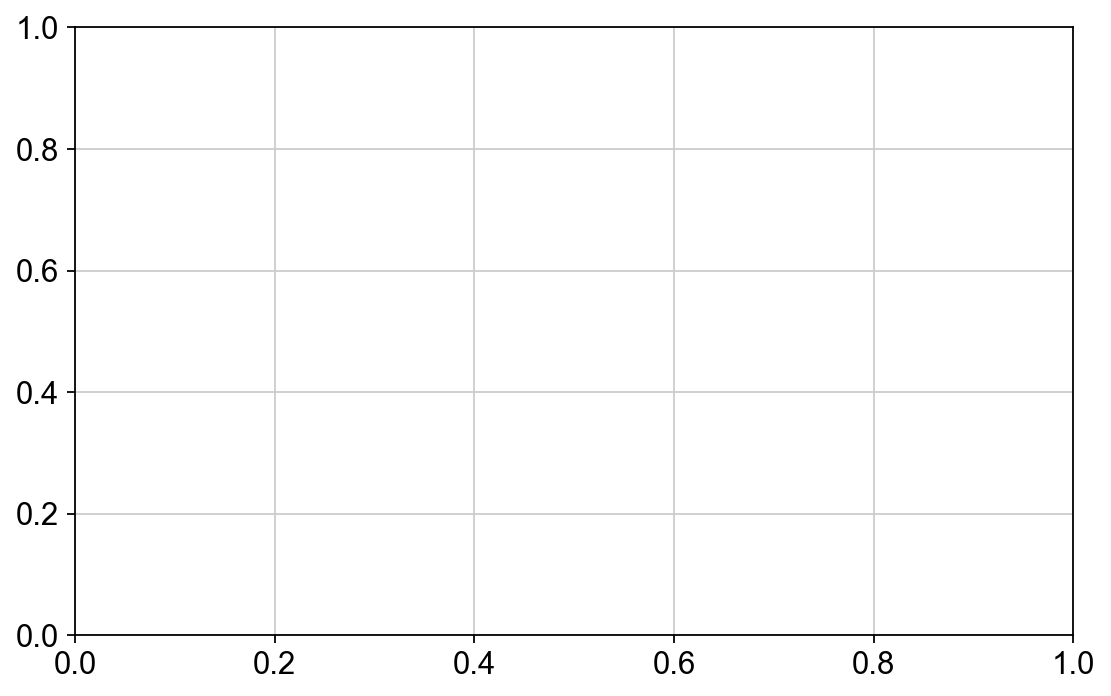

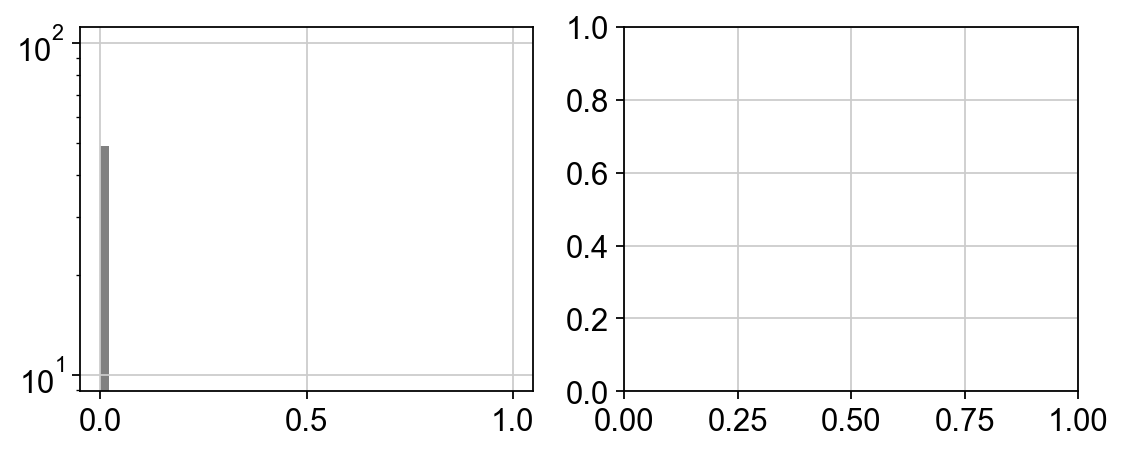

In [39]:
# Apply basic QC filters before doublet detection
print("Applying initial QC filters for doublet detection...")
adata_for_doublets = adata[
    (adata.obs.n_genes_by_counts >= CELL_FILTERS['min_genes']) &
    (adata.obs.n_genes_by_counts <= CELL_FILTERS['max_genes']) &
    (adata.obs.percent_mt <= CELL_FILTERS['max_mt_pct'])
].copy()

print(f"Cells for doublet detection: {adata_for_doublets.n_obs:,} (from {adata.n_obs:,})")

# Detect doublets
adata_for_doublets = detect_doublets_improved(
    adata_for_doublets,
    expected_doublet_rate=DOUBLET_PARAMS['expected_doublet_rate'],
    manual_threshold=DOUBLET_PARAMS['manual_threshold'],
    plot_histograms=True,
    save_dir=PLOTS_DIR,
)

# Transfer doublet annotations back to original adata
adata.obs['doublet_score'] = 0.0
adata.obs['predicted_doublet'] = False
adata.obs.loc[adata_for_doublets.obs.index, 'doublet_score'] = adata_for_doublets.obs['doublet_score']
adata.obs.loc[adata_for_doublets.obs.index, 'predicted_doublet'] = adata_for_doublets.obs['predicted_doublet']

In [ ]:
# ============================================================================
# TUNE DOUBLET DETECTION PARAMETERS BASED ON HISTOGRAM ABOVE
# ============================================================================
# 
# Review the doublet score histogram and adjust these values if needed.
# After adjusting, re-run Stage 3 (Doublet Detection) and Stage 4 (Filtering).
#
# Current values are shown for reference - modify as needed:
# ============================================================================

# Preview current settings
print("Current doublet detection settings:")
print(f"  expected_doublet_rate: {DOUBLET_PARAMS['expected_doublet_rate']} ({DOUBLET_PARAMS['expected_doublet_rate']*100}%)")
print(f"  manual_threshold: {DOUBLET_PARAMS['manual_threshold']}")

# Analyze doublet score distribution
if 'doublet_score' in adata.obs.columns:
    scores = adata.obs['doublet_score'].dropna()
    if len(scores) > 0:
        print("\n" + "="*50)
        print("DOUBLET SCORE STATISTICS:")
        print("="*50)
        print(f"  Mean: {scores.mean():.3f}")
        print(f"  Median: {scores.median():.3f}")
        print(f"  25th percentile: {scores.quantile(0.25):.3f}")
        print(f"  75th percentile: {scores.quantile(0.75):.3f}")
        print(f"  95th percentile: {scores.quantile(0.95):.3f}")
        print(f"  Current threshold: {DOUBLET_PARAMS['manual_threshold']}")
        print(f"  Cells above threshold: {(scores > DOUBLET_PARAMS['manual_threshold']).sum()} ({(scores > DOUBLET_PARAMS['manual_threshold']).sum()/len(scores)*100:.1f}%)")
        
        # Suggest threshold based on percentiles
        print("\n" + "="*50)
        print("THRESHOLD RECOMMENDATIONS:")
        print("="*50)
        print(f"  Conservative (75th percentile): {scores.quantile(0.75):.3f}")
        print(f"  Moderate (90th percentile): {scores.quantile(0.90):.3f}")
        print(f"  Permissive (95th percentile): {scores.quantile(0.95):.3f}")

print("\n" + "="*50)
print("TO ADJUST PARAMETERS:")
print("="*50)
print("Uncomment and modify the lines below, then re-run Stage 3:")
print("""
# DOUBLET_PARAMS['expected_doublet_rate'] = 0.10  # Platform-dependent (0.06-0.10)
# DOUBLET_PARAMS['manual_threshold'] = 0.35        # Adjust based on histogram (0.25-0.50)
""")


### 💡 Tuning Doublet Detection

**Key considerations:**

1. **Expected doublet rate**
   - 10x Chromium v2: ~4-6%
   - 10x Chromium v3: ~6-8%
   - High-throughput: ~8-10%
   - Check your platform specifications

2. **Manual threshold**
   - Default: 0.35
   - Lower (0.25-0.30): More stringent, removes more cells
   - Higher (0.40-0.50): More permissive, retains more cells
   - Examine histogram: clear separation = good, overlap = difficult

3. **What to check after clustering:**
   - Doublets should appear as intermediate clusters on UMAP
   - Check if "doublet clusters" express markers from 2+ cell types
   - If residual doublets remain, lower the threshold and re-run

## 6. Stage 4: Cell & Gene Filtering

Apply QC filters to remove low-quality cells and rarely-expressed genes.

**Filters Applied:**
- Remove doublets
- Filter cells by gene count, UMI count, and MT%
- Filter genes by minimum number of cells expressing

### 🔧 Review Filtering Results

**Review the plots above to verify filtering worked as expected.**

**What to check:**

1. **Cells per sample**: Should be relatively balanced (unless biological differences expected)
   - Large imbalances may indicate batch effects or sample-specific QC issues
   - Action: If needed, adjust QC thresholds per sample or investigate batch effects

2. **Gene count distribution**: Should show a clean, unimodal distribution
   - Remaining cells should be within your specified thresholds
   - Action: If distribution looks wrong, go back and adjust QC parameters in Stage 2

3. **MT% distribution**: Should be low and unimodal
   - Most cells should have <10% MT (tissue-dependent)
   - Action: If many cells still have high MT%, consider lowering `max_mt_pct`

**If filtering looks good, proceed to Stage 5 (Normalization). If not, adjust parameters in Stage 2 and re-run filtering.**


In [ ]:
def filter_cells_and_genes(adata, min_genes=200, max_genes=8000, max_mt_pct=10,
                          min_counts=1000, max_counts=50000, max_ribo_pct=None):
    """Filter cells and genes based on QC thresholds"""
    print("\nFiltering cells and genes...")
    print(f"  Starting: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
    
    # Filter cells
    n_before = adata.n_obs
    
    # Remove doublets
    adata = adata[~adata.obs['predicted_doublet']].copy()
    print(f"  After doublet removal: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    n_before = adata.n_obs
    
    # Apply QC filters
    sc.pp.filter_cells(adata, min_genes=min_genes)
    print(f"  After min_genes filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    n_before = adata.n_obs
    adata = adata[adata.obs.n_genes_by_counts <= max_genes].copy()
    print(f"  After max_genes filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    n_before = adata.n_obs
    adata = adata[adata.obs.total_counts >= min_counts].copy()
    print(f"  After min_counts filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    n_before = adata.n_obs
    adata = adata[adata.obs.total_counts <= max_counts].copy()
    print(f"  After max_counts filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    n_before = adata.n_obs
    adata = adata[adata.obs.percent_mt <= max_mt_pct].copy()
    print(f"  After MT% filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    if max_ribo_pct is not None:
        n_before = adata.n_obs
        adata = adata[adata.obs.percent_ribo <= max_ribo_pct].copy()
        print(f"  After ribo% filter: {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)")
    
    # Filter genes
    n_genes_before = adata.n_vars
    sc.pp.filter_genes(adata, min_cells=GENE_FILTERS['min_cells'])
    print(f"  After gene filter: {adata.n_vars:,} genes ({n_genes_before - adata.n_vars:,} removed)")
    
    print(f"\n  ✓ Final: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
    
    return adata

# Apply filters
adata = filter_cells_and_genes(
    adata,
    min_genes=CELL_FILTERS['min_genes'],
    max_genes=CELL_FILTERS['max_genes'],
    max_mt_pct=CELL_FILTERS['max_mt_pct'],
    min_counts=CELL_FILTERS['min_counts'],
    max_counts=CELL_FILTERS['max_counts'],
    max_ribo_pct=CELL_FILTERS['max_ribo_pct'],
)

In [ ]:
# Visualize filtered data statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cells per sample
sample_counts = adata.obs['sample'].value_counts().sort_index()
axes[0].bar(range(len(sample_counts)), sample_counts.values)
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Cells per sample (after filtering)')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticklabels(sample_counts.index, rotation=90, ha='right')

# QC metrics distribution (filtered)
axes[1].hist(adata.obs['n_genes_by_counts'], bins=50, alpha=0.7)
axes[1].set_xlabel('Genes per cell')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Gene count distribution (filtered)')

axes[2].hist(adata.obs['percent_mt'], bins=50, alpha=0.7, color='orange')
axes[2].set_xlabel('MT %')
axes[2].set_ylabel('Frequency')
axes[2].set_title('MT% distribution (filtered)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'filtered_data_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Filtered data summary saved to {PLOTS_DIR}/filtered_data_summary.png")

## 7. Stage 5: Normalization & Scaling

Normalize counts to account for sequencing depth differences and identify highly variable genes.

**Steps:**
1. Normalize total counts per cell to 10,000
2. Log-transform (log1p)
3. Identify highly variable genes (HVGs)
4. Scale data (zero mean, unit variance)

**No parameters to tune in this stage.**

In [ ]:
def normalize_and_scale(adata):
    """Normalize and scale data"""
    print("\nNormalizing and scaling data...")
    
    # Save raw counts
    adata.raw = adata
    
    # Normalize to 10,000 reads per cell
    sc.pp.normalize_total(adata, target_sum=1e4)
    print("  ✓ Normalized to 10,000 counts per cell")
    
    # Log transform
    sc.pp.log1p(adata)
    print("  ✓ Log-transformed")
    
    # Find highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    n_hvg = adata.var['highly_variable'].sum()
    print(f"  ✓ Identified {n_hvg:,} highly variable genes")
    
    # Plot highly variable genes
    sc.pl.highly_variable_genes(adata, show=False)
    plt.savefig(PLOTS_DIR / 'highly_variable_genes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Keep only HVGs for downstream analysis
    adata = adata[:, adata.var.highly_variable]
    print(f"  ✓ Subset to {adata.n_vars:,} HVGs")
    
    # Scale data
    sc.pp.scale(adata, max_value=10)
    print("  ✓ Scaled data (max value = 10)")
    
    return adata

# Normalize and scale
adata = normalize_and_scale(adata)

## 8. Stage 6: PCA, UMAP & Clustering

Reduce dimensionality and identify cell clusters.

**Key Parameters:**
- `N_PCS`: Number of principal components
- `N_NEIGHBORS`: kNN graph neighbors
- `auto_resolution`: Automatically select Leiden resolution
- `resolution`: Manual Leiden resolution (if auto disabled)

In [ ]:
# Run PCA
print("\nRunning PCA...")
sc.tl.pca(adata, svd_solver='arpack', n_comps=N_PCS_COMPUTE)

# Plot elbow plot
sc.pl.pca_variance_ratio(adata, n_pcs=N_PCS_COMPUTE, log=True, show=False)
plt.axvline(N_PCS, color='r', linestyle='--', label=f'Selected: {N_PCS} PCs')
plt.legend()
plt.savefig(PLOTS_DIR / 'pca_elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  ✓ Computed {N_PCS_COMPUTE} PCs, using {N_PCS} for downstream analysis")

### 💡 Choosing Number of PCs

Look at the elbow plot above:
- **Elbow point**: Where variance explained starts to plateau
- **Typical range**: 15-40 PCs
- **Too few**: May miss biological variation
- **Too many**: May include noise

**Action**: If the elbow appears at a different point than your selected `N_PCS`, adjust the parameter above and re-run.

In [ ]:
# Compute neighborhood graph
print("\nComputing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=N_NEIGHBORS, n_pcs=N_PCS)
print(f"  ✓ Built kNN graph with {N_NEIGHBORS} neighbors using {N_PCS} PCs")

In [ ]:
# Run UMAP
print("\nRunning UMAP...")
sc.tl.umap(adata)
print("  ✓ UMAP embedding computed")

# Quick preview of UMAP (colored by sample)
sc.pl.umap(adata, color='sample', show=False)
plt.title('UMAP colored by sample')
plt.show()

In [ ]:
# ============================================================================
# TUNE CLUSTERING PARAMETERS BASED ON PLOTS ABOVE
# ============================================================================
# 
# Review the PCA elbow plot and UMAP embeddings, then adjust these values if needed.
# After adjusting, re-run Stage 6 (PCA, UMAP & Clustering) to apply changes.
#
# Current values are shown for reference - modify as needed:
# ============================================================================

# Preview current settings
print("Current clustering settings:")
print(f"  N_PCS: {N_PCS}")
print(f"  N_PCS_COMPUTE: {N_PCS_COMPUTE}")
print(f"  N_NEIGHBORS: {N_NEIGHBORS}")
print(f"  Auto resolution: {CLUSTERING_PARAMS['auto_resolution']}")
print(f"  Manual resolution: {CLUSTERING_PARAMS['resolution']}")
print(f"  Resolution grid: {CLUSTERING_PARAMS['resolution_grid']}")

# Analyze current clustering
if 'leiden' in adata.obs.columns:
    n_clusters = adata.obs['leiden'].nunique()
    cluster_sizes = adata.obs['leiden'].value_counts()
    print("\n" + "="*50)
    print("CURRENT CLUSTERING STATISTICS:")
    print("="*50)
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Smallest cluster: {cluster_sizes.min()} cells")
    print(f"  Largest cluster: {cluster_sizes.max()} cells")
    print(f"  Median cluster size: {cluster_sizes.median():.0f} cells")
    print(f"  Clusters with <{CLUSTERING_PARAMS['min_cluster_size']} cells: {(cluster_sizes < CLUSTERING_PARAMS['min_cluster_size']).sum()}")
    
    if (cluster_sizes < CLUSTERING_PARAMS['min_cluster_size']).sum() > n_clusters * 0.2:
        print("\n  ⚠ Warning: >20% of clusters are small - consider decreasing resolution")
    if n_clusters < 5:
        print("\n  ⚠ Warning: Very few clusters - consider increasing resolution")
    if n_clusters > 50:
        print("\n  ⚠ Warning: Many clusters - consider decreasing resolution")

# Check PCA variance if available
if 'pca' in adata.uns and 'variance_ratio' in adata.uns['pca']:
    variance_ratio = adata.uns['pca']['variance_ratio']
    cumsum_variance = np.cumsum(variance_ratio[:N_PCS_COMPUTE])
    print("\n" + "="*50)
    print("PCA VARIANCE EXPLAINED:")
    print("="*50)
    print(f"  Variance explained by first {N_PCS} PCs: {cumsum_variance[N_PCS-1]:.1%}")
    print(f"  Variance explained by first {N_PCS_COMPUTE} PCs: {cumsum_variance[N_PCS_COMPUTE-1]:.1%}")
    print(f"  Variance per PC (first 10): {[f'{v:.2%}' for v in variance_ratio[:10]]}")

print("\n" + "="*50)
print("TO ADJUST PARAMETERS:")
print("="*50)
print("Uncomment and modify the lines below, then re-run Stage 6:")
print("""
# N_PCS = 20                    # Adjust based on elbow plot (typically 15-40)
# N_NEIGHBORS = 15              # Adjust for smoother (increase) or finer (decrease) structure
# CLUSTERING_PARAMS['auto_resolution'] = False  # Set to False to use manual resolution
# CLUSTERING_PARAMS['resolution'] = 0.8         # Adjust based on cluster count (0.4-1.5 typical)
# CLUSTERING_PARAMS['resolution_grid'] = [i/10 for i in range(4, 13)]  # Range to test if auto=True
""")


In [ ]:
# Leiden clustering
print("\nRunning Leiden clustering...")

if CLUSTERING_PARAMS['auto_resolution']:
    print("  Using automatic resolution selection")
    # This would call a resolution sweep function - simplified here
    # For full implementation, see utils/processing.py
    print(f"  Testing resolutions: {CLUSTERING_PARAMS['resolution_grid']}")
    
    # For demo, just use fixed resolution
    # In practice, implement choose_leiden_resolution() function
    chosen_resolution = CLUSTERING_PARAMS['resolution']
    print(f"  Selected resolution: {chosen_resolution}")
else:
    chosen_resolution = CLUSTERING_PARAMS['resolution']
    print(f"  Using manual resolution: {chosen_resolution}")

sc.tl.leiden(adata, resolution=chosen_resolution)
n_clusters = adata.obs['leiden'].nunique()
print(f"  ✓ Identified {n_clusters} clusters")

# Store chosen resolution
adata.uns['leiden_resolution'] = chosen_resolution

In [ ]:
# Plot UMAP with various colorings
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sc.pl.umap(adata, color='leiden', legend_loc='on data', 
          title='Leiden clustering', ax=axes[0, 0], show=False)

sc.pl.umap(adata, color='Genotype', title='Genotype', 
          ax=axes[0, 1], show=False)

sc.pl.umap(adata, color='Sex', title='Sex', 
          ax=axes[1, 0], show=False)

sc.pl.umap(adata, color='Stimulation', title='Stimulation', 
          ax=axes[1, 1], show=False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'umap_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ UMAP plots saved to {PLOTS_DIR}/umap_embeddings.png")

### 💡 Interpreting Clusters

**Good clustering:**
- Distinct, separated clusters on UMAP
- Clusters are not driven by batch effects (check sample/genotype plots)
- Biologically interpretable based on marker genes

**Potential issues:**
- **Too many tiny clusters**: Increase resolution or min_cluster_size
- **Too few broad clusters**: Decrease resolution
- **Batch-driven clustering**: Cells cluster by sample rather than biology → consider batch correction
- **Doublet clusters**: Check if some clusters have intermediate positions and mixed markers

## 9. Stage 7: Marker Gene Analysis

Identify differentially expressed genes for each cluster.

**Parameters:**
- `method`: 'wilcoxon' (default), 't-test', or 'logreg'
- `n_top`: Number of top markers to report per cluster

In [ ]:
# Compute marker genes
print("\nComputing marker genes per cluster...")
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', 
                        use_raw=True, key_added='rank_genes_groups')

print("  ✓ Marker genes computed")

# Display top markers
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=False)
plt.savefig(PLOTS_DIR / 'top_marker_genes.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Export top markers to CSV
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

markers_dict = {}
for group in groups:
    markers_dict[f'Cluster_{group}_genes'] = result['names'][group][:30]
    markers_dict[f'Cluster_{group}_scores'] = result['scores'][group][:30]
    markers_dict[f'Cluster_{group}_pvals'] = result['pvals_adj'][group][:30]

markers_df = pd.DataFrame(markers_dict)
markers_df.to_csv(PLOTS_DIR / 'top_markers_by_cluster.csv', index=False)

print(f"\n✓ Top markers saved to {PLOTS_DIR}/top_markers_by_cluster.csv")
print("\nTop 5 markers for first 3 clusters:")
display(markers_df.iloc[:5, :9])

In [ ]:
# Plot canonical marker genes
print("\nPlotting canonical marker genes...")

# Collect available markers
available_markers = []
for cell_type, genes in MARKER_GENES.items():
    available = [g for g in genes if g in adata.raw.var_names]
    available_markers.extend(available)

# Deduplicate while preserving order
seen = set()
available_markers = [g for g in available_markers if not (g in seen or seen.add(g))]

if available_markers:
    sc.pl.dotplot(adata, available_markers, groupby='leiden', 
                 standard_scale='var', figsize=(15, 8), show=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'marker_genes_dotplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Dotplot saved with {len(available_markers)} marker genes")
else:
    print("  ⚠ No canonical marker genes found in dataset")

### 💡 Validating Clusters with Markers

**Review the marker genes:**

1. **Check top genes per cluster**
   - Are they biologically meaningful?
   - Do they make sense for your tissue type?

2. **Check canonical markers (dotplot)**
   - Identify major cell types (neurons, glia, vascular, etc.)
   - Look for clear expression patterns

3. **Red flags:**
   - Clusters with generic/housekeeping genes as top markers
   - Multiple clusters with same markers → may need coarser resolution
   - No clear marker expression → may need finer resolution

**Next step**: Use these markers to assign cell type labels in Stage 8

## 10. Stage 8: Cell Type Annotation

Assign cell type labels based on marker gene expression.

**Key Parameters:**
- `label_mode`: 'cell' for per-cell scoring, 'cluster' for cluster-level
- `margin`: Confidence threshold for assignment

In [ ]:
# ============================================================================
# TUNE ANNOTATION PARAMETERS BASED ON PLOTS ABOVE
# ============================================================================
# 
# Review the cell type UMAP and composition heatmap, then adjust these values if needed.
# After adjusting, re-run Stage 8 (Cell Type Annotation) to apply changes.
#
# Current values are shown for reference - modify as needed:
# ============================================================================

# Preview current settings
print("Current annotation settings:")
print(f"  label_mode: {ANNOTATION_PARAMS['label_mode']}")
print(f"  margin: {ANNOTATION_PARAMS['margin']}")
print(f"  cluster_agg: {ANNOTATION_PARAMS['cluster_agg']}")
print(f"  Number of marker gene sets: {len(MARKER_GENES)}")

# Analyze current annotations
if 'celltype' in adata.obs.columns:
    print("\n" + "="*50)
    print("CURRENT ANNOTATION STATISTICS:")
    print("="*50)
    celltype_counts = adata.obs['celltype'].value_counts()
    print(f"  Total cell types identified: {celltype_counts.nunique()}")
    print(f"  Unlabeled cells: {(adata.obs['celltype'] == 'Unlabeled').sum()} ({(adata.obs['celltype'] == 'Unlabeled').sum()/len(adata)*100:.1f}%)")
    print(f"\n  Top 10 cell types:")
    for ct, count in celltype_counts.head(10).items():
        print(f"    {ct}: {count:,} cells ({count/len(adata)*100:.1f}%)")
    
    # Check spatial coherence (cell types should cluster together)
    if 'leiden' in adata.obs.columns:
        print("\n" + "="*50)
        print("SPATIAL COHERENCE (cell type distribution across clusters):")
        print("="*50)
        ct_cluster = pd.crosstab(adata.obs['celltype'], adata.obs['leiden'])
        # Find cell types that are spread across many clusters (poor coherence)
        n_clusters_per_ct = (ct_cluster > 0).sum(axis=1)
        print(f"  Average clusters per cell type: {n_clusters_per_ct.mean():.1f}")
        if n_clusters_per_ct.max() > n_clusters_per_ct.median() * 2:
            print(f"  ⚠ Warning: Some cell types span many clusters (max: {n_clusters_per_ct.max()})")
            print(f"    This may indicate: (1) cell type is heterogeneous, (2) markers need refinement, or (3) clustering resolution too high")

print("\n" + "="*50)
print("TO ADJUST PARAMETERS:")
print("="*50)
print("Uncomment and modify the lines below, then re-run Stage 8:")
print("""
# ANNOTATION_PARAMS['label_mode'] = 'cluster'  # Use 'cluster' for more robust annotations
# ANNOTATION_PARAMS['margin'] = 0.10            # Increase for more conservative labeling (0.05-0.15)
# ANNOTATION_PARAMS['cluster_agg'] = 'median'   # 'median' or 'mean' (only used if label_mode='cluster')

# To add/refine marker genes, modify the MARKER_GENES dictionary:
# MARKER_GENES['YourCellType'] = ['Gene1', 'Gene2', 'Gene3']
""")


In [ ]:
# Score cells for each cell type based on marker expression
print("\nScoring cells for major cell types...")

for cell_type, genes in MARKER_GENES.items():
    # Filter to genes present in dataset
    available_genes = [g for g in genes if g in adata.raw.var_names]
    
    if available_genes:
        sc.tl.score_genes(adata, available_genes, 
                         score_name=f'{cell_type}_score', 
                         use_raw=True)
        print(f"  ✓ {cell_type}: {len(available_genes)}/{len(genes)} markers")
    else:
        print(f"  ⚠ {cell_type}: No markers found")

print("\n✓ Cell type scoring complete")

In [ ]:
# Assign cell types based on highest score
print("\nAssigning cell type labels...")

# Get score columns
score_cols = [col for col in adata.obs.columns if col.endswith('_score')]

if score_cols:
    # For each cell, find the cell type with highest score
    scores = adata.obs[score_cols]
    
    # Get max score and second-best score for confidence margin
    scores_sorted = np.sort(scores.values, axis=1)
    max_scores = scores_sorted[:, -1]
    second_scores = scores_sorted[:, -2] if scores.shape[1] > 1 else scores_sorted[:, -1]
    
    # Apply margin threshold
    confident = (max_scores - second_scores) > ANNOTATION_PARAMS['margin']
    
    # Assign labels
    adata.obs['celltype'] = scores.idxmax(axis=1).str.replace('_score', '')
    adata.obs.loc[~confident, 'celltype'] = 'Unlabeled'
    
    # Summary
    print("\nCell type distribution:")
    print(adata.obs['celltype'].value_counts())
    print(f"\nConfidently labeled: {confident.sum():,} / {len(confident):,} "
          f"({confident.sum()/len(confident)*100:.1f}%)")
else:
    print("  ⚠ No cell type scores found")

In [ ]:
# Plot cell types on UMAP
if 'celltype' in adata.obs.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sc.pl.umap(adata, color='celltype', ax=axes[0], show=False,
              title='Cell type annotations')
    
    sc.pl.umap(adata, color='leiden', legend_loc='on data', 
              ax=axes[1], show=False, title='Leiden clusters')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'cell_type_umap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Cell type composition per cluster
    ct_composition = pd.crosstab(adata.obs['leiden'], adata.obs['celltype'], 
                                normalize='index')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_composition, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Cell type composition per cluster')
    plt.xlabel('Cell type')
    plt.ylabel('Leiden cluster')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'celltype_composition_heatmap.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Cell type plots saved to {PLOTS_DIR}")

### 💡 Refining Cell Type Annotations

**Check your annotations:**

1. **Spatial coherence**: Cell types should cluster together on UMAP
2. **Biological plausibility**: Do the proportions make sense?
3. **Marker validation**: Go back to dotplot and verify markers align with labels

**If annotations look wrong:**
- Increase `margin` for more conservative labeling
- Switch to `label_mode='cluster'` for more robust assignments
- Add/refine marker genes in MARKER_GENES dictionary
- Consider manual curation for difficult clusters

## 11. Stage 9: Reclustering & Export

Optionally recluster specific cell types for finer resolution and export final results.

In [ ]:
# Optional: Recluster excitatory neurons for layer-specific analysis
print("\nReclustering excitatory neurons...")

if 'celltype' in adata.obs.columns:
    # Subset excitatory neurons
    excit_cells = adata.obs['celltype'].isin(['Excit', 'ExN', 'Neuron'])
    
    if excit_cells.sum() > 100:  # Only if we have enough cells
        adata_excit = adata[excit_cells].copy()
        
        # Re-run processing on subset
        sc.pp.highly_variable_genes(adata_excit, n_top_genes=3000)
        sc.pp.scale(adata_excit, max_value=10)
        sc.tl.pca(adata_excit, n_comps=30)
        sc.pp.neighbors(adata_excit, n_neighbors=15, n_pcs=30)
        sc.tl.umap(adata_excit)
        sc.tl.leiden(adata_excit, resolution=0.8, key_added='excit_leiden')
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sc.pl.umap(adata_excit, color='excit_leiden', legend_loc='on data',
                  ax=axes[0], show=False, title='Excitatory neuron subclusters')
        
        # Check layer markers
        layer_markers = ['Cux1', 'Cux2', 'Bcl11b', 'Fezf2', 'Tbr1']
        available_layer_markers = [g for g in layer_markers if g in adata_excit.raw.var_names]
        
        if available_layer_markers:
            sc.pl.umap(adata_excit, color=available_layer_markers[0],
                      ax=axes[1], show=False, title=f'{available_layer_markers[0]} expression')
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'excitatory_neuron_reclustering.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"  ✓ Reclustered {adata_excit.n_obs:,} excitatory neurons")
        print(f"  ✓ Identified {adata_excit.obs['excit_leiden'].nunique()} subclusters")
    else:
        print(f"  ⚠ Only {excit_cells.sum()} excitatory neurons found - skipping reclustering")
else:
    print("  ⚠ No cell type annotations found - skipping reclustering")

In [ ]:
# Export final annotated data
output_file = 'annotated_cellbender_data.h5ad'
adata.write(output_file)

print(f"\n✓ Saved annotated data to {output_file}")
print(f"  Dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"  Metadata columns: {list(adata.obs.columns)}")
print(f"  Embeddings: {list(adata.obsm.keys())}")

In [ ]:
# Export metadata to CSV for easy viewing
metadata_cols = ['sample', 'leiden', 'celltype', 'Genotype', 'Sex', 'Stimulation',
                'n_genes_by_counts', 'total_counts', 'percent_mt', 'doublet_score']
available_cols = [col for col in metadata_cols if col in adata.obs.columns]

adata.obs[available_cols].to_csv(PLOTS_DIR / 'cell_metadata.csv')
print(f"\n✓ Exported cell metadata to {PLOTS_DIR}/cell_metadata.csv")

# Summary statistics
summary = pd.DataFrame({
    'Metric': [
        'Total cells',
        'Total genes',
        'Number of clusters',
        'Number of cell types',
        'Median genes per cell',
        'Median UMIs per cell',
    ],
    'Value': [
        f"{adata.n_obs:,}",
        f"{adata.n_vars:,}",
        adata.obs['leiden'].nunique() if 'leiden' in adata.obs else 'N/A',
        adata.obs['celltype'].nunique() if 'celltype' in adata.obs else 'N/A',
        f"{adata.obs['n_genes_by_counts'].median():.0f}",
        f"{adata.obs['total_counts'].median():.0f}",
    ]
})

summary.to_csv(PLOTS_DIR / 'analysis_summary.csv', index=False)
print(f"✓ Exported analysis summary to {PLOTS_DIR}/analysis_summary.csv")
print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)
display(summary)

## 12. Summary & Next Steps

### ✅ Pipeline Complete!

You have successfully:
1. ✓ Loaded and integrated CellBender data
2. ✓ Performed quality control and filtering
3. ✓ Detected and removed doublets
4. ✓ Normalized and scaled data
5. ✓ Performed dimensionality reduction (PCA, UMAP)
6. ✓ Identified cell clusters
7. ✓ Computed marker genes
8. ✓ Annotated cell types
9. ✓ Exported results

### 📊 Output Files

All results are in the `plots/` directory:
- `annotated_cellbender_data.h5ad` - Final annotated dataset
- `cell_metadata.csv` - Cell-level metadata
- `top_markers_by_cluster.csv` - Marker genes per cluster
- `analysis_summary.csv` - Summary statistics
- Various plots (UMAP, QC, markers, etc.)

### 🔬 Next Steps

1. **Differential Expression Analysis**
   - Compare cell types or conditions
   - Use tools like DESeq2, edgeR, or scanpy's rank_genes_groups

2. **Pathway Analysis**
   - Gene set enrichment analysis (GSEA)
   - GO term enrichment

3. **Cell-Cell Communication**
   - CellPhoneDB, NicheNet, CellChat

4. **Trajectory Analysis**
   - Pseudotime analysis with Monocle, PAGA, or RNA velocity

5. **Integration with Other Datasets**
   - Compare with published atlases
   - Batch correction if combining multiple experiments

### 📚 Resources

- [Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/)
- [Single-cell best practices](https://www.sc-best-practices.org/)
- [Seurat documentation](https://satijalab.org/seurat/)

### 🐛 Troubleshooting

If you encounter issues:
1. Check parameter settings in Section 2
2. Review QC plots for quality issues
3. Adjust filtering thresholds and re-run affected sections
4. Validate marker genes match your expectations

---

**Happy analyzing! 🎉**